In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from PIL import Image
import gradio as gr
import argparse
import gdown
import cv2
import numpy as np
import os
import sys
sys.path.append(sys.path[0] + "/tracker")
sys.path.append(sys.path[0] + "/tracker/model")
from track_anything import TrackingAnything
from track_anything import parse_augment
import requests
import json
import torchvision
import torch
from tools.painter import mask_painter
import psutil
import time

In [5]:
from cli import download_checkpoint, download_checkpoint_from_google_drive
from cli import vos_tracking_video
from cli import get_frames_from_video
from cli import sam_refine, get_prompt

In [6]:
args = argparse.Namespace()
args.sam_model_type = "vit_h"
args.device = "cpu"
from pathlib import Path
args.input_video = Path("test_sample/mall_480.mp4")
args.debug = True
# args.port = 12212
# args.device = "cuda:1"
args.mask_save = True
# initialize sam, xmem, e2fgvi models

In [7]:

print("Woo hoo!")

# args, defined in track_anything.py
# args = parse_augment()

# check and download checkpoints if needed
SAM_checkpoint_dict = {
    "vit_h": "sam_vit_h_4b8939.pth",
    "vit_l": "sam_vit_l_0b3195.pth",
    "vit_b": "sam_vit_b_01ec64.pth",
}
SAM_checkpoint_url_dict = {
    "vit_h": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
    "vit_l": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
    "vit_b": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
}
sam_checkpoint = SAM_checkpoint_dict[args.sam_model_type]
sam_checkpoint_url = SAM_checkpoint_url_dict[args.sam_model_type]
xmem_checkpoint = "XMem-s012.pth"
xmem_checkpoint_url = (
    "https://github.com/hkchengrex/XMem/releases/download/v1.0/XMem-s012.pth"
)
e2fgvi_checkpoint = "E2FGVI-HQ-CVPR22.pth"
e2fgvi_checkpoint_id = "10wGdKSUOie0XmCr8SQ2A2FeDe-mfn5w3"

folder = "./checkpoints"
SAM_checkpoint = download_checkpoint(sam_checkpoint_url, folder, sam_checkpoint)
xmem_checkpoint = download_checkpoint(xmem_checkpoint_url, folder, xmem_checkpoint)
e2fgvi_checkpoint = download_checkpoint_from_google_drive(
    e2fgvi_checkpoint_id, folder, e2fgvi_checkpoint
)

model = TrackingAnything(SAM_checkpoint, xmem_checkpoint, None, args)

Woo hoo!
download checkpoints ......


PermissionError: [Errno 13] Permission denied: './checkpoints/sam_vit_h_4b8939.pth'

In [ ]:
import pickle
sam_refine_args = pickle.load(
    Path('test_sample/mall_480/sam_refine_args.pkl').open('rb')
)

In [ ]:
vos_tracking_video_args = pickle.load(
    Path('test_sample/mall_480/vos_tracking_video_args.pkl').open('rb')
)

In [ ]:
interactive_state = {
    "inference_times": 0,
    "negative_click_times": 0,
    "positive_click_times": 0,
    "mask_save": args.mask_save,
    "multi_mask": {"mask_names": [], "masks": []},
    "track_end_number": None,
    "resize_ratio": 1,
}
video_state = {
    "user_name": "",
    "video_name": "",
    "origin_images": None,
    "painted_images": None,
    "masks": None,
    "inpaint_masks": None,
    "logits": None,
    "select_frame_number": 0,
    "fps": 25,
}

video_state, video_info, origin_image = get_frames_from_video(
    model,
    args.input_video,
    video_state,
)

In [ ]:
from matplotlib import pyplot as plt

# plt.imshow(
# origin_image
# )

# plt.imshow(
#     video_state["origin_images"][-1]
# )


In [ ]:
sam_refine_args['point_prompt'], \
sam_refine_args['click_state'],

('Positive', [[], []])

In [ ]:
sam_refine_args['interactive_state'], \
interactive_state

({'inference_times': 0,
  'negative_click_times': 0,
  'positive_click_times': 0,
  'mask_save': False,
  'multi_mask': {'mask_names': [], 'masks': []},
  'track_end_number': None,
  'resize_ratio': 1},
 {'inference_times': 0,
  'negative_click_times': 0,
  'positive_click_times': 0,
  'mask_save': True,
  'multi_mask': {'mask_names': [], 'masks': []},
  'track_end_number': None,
  'resize_ratio': 1})

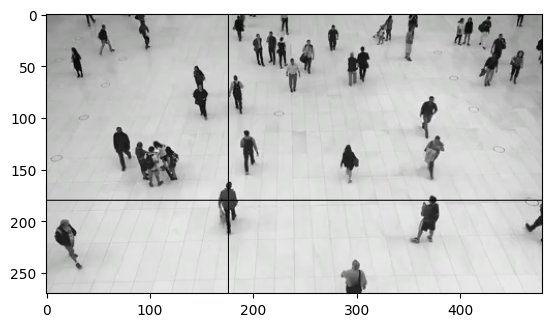

In [ ]:
x = video_state["origin_images"][0].copy()
x[180,:] = 0
x[:,176] = 0
plt.imshow(
    x
)

In [ ]:
evt = argparse.Namespace()
evt.index = [0, 0]
template_frame, video_state, interactive_state, run_status = sam_refine(
    model=model,
    video_state=video_state,
    # point_prompt=sam_refine_args['point_prompt'],
    point_prompt="Positive",
    click_state=[[180,176],[1]],
    prompt={
        "prompt_type": ["click"],
        "input_point": [[180,176]],
        "input_label": [1],
        "multimask_output": "False",
    },
    interactive_state=interactive_state,
    evt=evt,
)

In [ ]:
from cli import vos_tracking_video
video_output, video_state, interactive_state, run_status = vos_tracking_video(
    model=model,
    video_state=video_state,
    interactive_state=interactive_state,
    mask_dropdown=[],
)

Tracking image: 100%|██████████| 171/171 [01:06<00:00,  2.56it/s]


For generating this tracking result, inference times: 1, click times: 0, positive: 0, negative: 0
save mask


In [ ]:
import argparse

args = argparse.Namespace()

args.output = Path('mall_480.json')
masks = Path('result/mask/mall_480').glob('*.npy')


In [ ]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import json


outputs = []

def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    try:
        rmin, rmax = np.where(rows)[0][[0, -1]].tolist()
        cmin, cmax = np.where(cols)[0][[0, -1]].tolist()
        return rmin, rmax, cmin, cmax
    except IndexError:
        return None
for i, mask in enumerate(sorted(masks)):
    # print(mask)
    # print(i)
    mask = np.load(mask)
    # Get bounding box [x,y,x,y] from binary mask
    bbox = bbox2(mask > 0)
    if bbox is not None:
        # Write outputs in {1: {'class': 0, 'bbox': [0, 0, 0, 0], 'score': ''}} format
        outputs.append({i: {'class': 0, 'bbox': bbox, 'score': ''}})

# Write outputs to json
Path(args.output).open('w').write(json.dumps({
    'results': outputs
}, indent=4))

35527

## Output BBoxes on the screen

In [ ]:

# track_pause_number_slider.release(
#     fn=get_end_number,
#     inputs=[track_pause_number_slider, video_state, interactive_state],
#     outputs=[template_frame, interactive_state, run_status],
#     api_name="end_image",
# )

evt = argparse.Namespace()
evt.index = [0, 0]
template_frame, video_state, interactive_state, run_status = sam_refine(
    model=model,
    video_state=video_state,
    # point_prompt=sam_refine_args['point_prompt'],
    point_prompt=None,#"Positive",
    click_state=None,#[[180,176],[1]],
    prompt={
        "prompt_type": ["click"],
        "input_point": [points[0]['pos']],#[[180,176]],
        "input_label": [points[0]['label']],
        "multimask_output": "False",
    },
    interactive_state=interactive_state,
    evt=evt,
)
video_output, video_state, interactive_state, run_status = vos_tracking_video(
    model=model,
    video_output=args.output_video,
    video_state=video_state,
    interactive_state=interactive_state,
    mask_dropdown=[],
)
outputs = []

def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    try:
        rmin, rmax = np.where(rows)[0][[0, -1]].tolist()
        cmin, cmax = np.where(cols)[0][[0, -1]].tolist()
        return rmin, rmax, cmin, cmax
    except IndexError:
        return None
# video_state["masks"][video_state["select_frame_number"]] = mask
for frame_num, mask in enumerate(video_state["masks"]):
    # print(mask)
    # print(i)
    # mask = np.load(mask)
    # Get bounding box [x,y,x,y] from binary mask
    bbox = bbox2(mask > 0)
    if bbox is not None:
        # Write outputs in {1: {'class': 0, 'bbox': [0, 0, 0, 0], 'score': ''}} format
        outputs.append({frame_num: {'class': 0, 'bbox': bbox, 'score': ''}})

# Write outputs to json
Path(args.output).open('w').write(json.dumps({
    'results': outputs
}, indent=4))